## Select seed

In [1]:
import sys
my_seed = 0 # int(sys.argv[1])

## Filenames to save results in npy format per method

In [2]:
filename_olh = 'results/adults/OLH_'

## Numba and Ray libraries for speeding up things

In [ ]:
from numba import jit
import ray

## GRR function

In [4]:
@jit(nopython=True)
def GRR(x, lst_val, p, q):
    """
    GRR mechanism
    input: true value x, domain values 'lst_val', and probabilities p,q
    output: true value w.p. 'p', random value (except x) w.p. 'q'
    """
    
    rnd = np.random.random()

    if rnd <=p:    
        return x
    else:
        return np.random.choice(lst_val[lst_val !=x]) 

## LH function

In [5]:
from sys import maxsize
import xxhash

def LH_Client(input_data, epsilon, optimal=True):
    
    """
    Local Hashing (LH) protocol.
    :param input_data: user's true value;
    :param epsilon: privacy guarantee;
    :param optimal: if True, it uses the Optimized LH (OLH) protocol from [1];
    :return: tuple of sanitized value and random seed.
    """
    
    # Binary LH (BLH) parameter
    g = 2
    
    # Optimal LH (OLH) parameter
    if optimal:
        g = int(round(np.exp(epsilon))) + 1
    
    # GRR parameters with reduced domain size g
    p = np.exp(epsilon) / (np.exp(epsilon) + g - 1)
    q = 1 / (np.exp(epsilon) + g - 1)
    
    # Generate random seed and hash the user's value
    rnd_seed = np.random.randint(0, maxsize, dtype=np.int64)
    hashed_input_data = (xxhash.xxh32(str(input_data), seed=rnd_seed).intdigest() % g)
    
    # LH perturbation function (i.e., GRR-based)
    sanitized_value = hashed_input_data
    rnd = np.random.random()
    if rnd > p - q:
        
        sanitized_value = np.random.randint(0, g)
        
    return (sanitized_value, rnd_seed)

## Main libraries

In [6]:
import warnings; warnings.simplefilter('ignore')
import pandas as pd; pd.set_option('mode.chained_assignment',None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import copy

import time
import csv
from pandas.core.common import flatten

#config for plots
import matplotlib
params = {'axes.titlesize':'16',
          'xtick.labelsize':'16',
          'ytick.labelsize':'16',
          'font.size':'16',
          'legend.fontsize':'medium',
          'lines.linewidth':'2',
          'font.weight':'normal',
          'lines.markersize':'10'
          }
matplotlib.rcParams.update(params)
plt.rcParams["mathtext.fontset"] = "cm"
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Reading dataset

In [7]:
df = pd.read_csv('db_adults.csv')
df = df.sample(frac=0.01)
df.reset_index(inplace=True, drop=True)
df.reset_index(inplace=True)
df.rename(columns={'index': 'ID', 'marital-status': 'marital_status', 'native-country': 'native_country'}, inplace=True)
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,39,Private,HS-grad,Never-married,Craft-repair,Own-child,White,Male,United-States,<=50K
1,1,59,Private,9th,Widowed,Handlers-cleaners,Unmarried,White,Male,United-States,<=50K
2,2,32,Private,Some-college,Married-civ-spouse,Sales,Husband,White,Male,United-States,<=50K
3,3,35,Private,HS-grad,Married-civ-spouse,Handlers-cleaners,Husband,White,Male,Mexico,<=50K
4,4,42,Private,Bachelors,Never-married,Sales,Not-in-family,White,Male,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...
447,447,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
448,448,40,Local-gov,HS-grad,Married-civ-spouse,Adm-clerical,Wife,Amer-Indian-Eskimo,Female,United-States,<=50K
449,449,59,Private,11th,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,United-States,<=50K
450,450,22,Private,HS-grad,Never-married,Handlers-cleaners,Own-child,White,Male,United-States,<=50K


## Dataset to work with

In [8]:
attributes = list(df.drop('ID', axis=1).columns)

LE = LabelEncoder()

for col in attributes:
    df[col] = LE.fit_transform(df[col])
df

,ID,age,workclass,education,marital_status,occupation,relationship,race,sex,native_country,salary
0,0,22,2,11,3,1,3,4,1,18,0
1,1,42,2,6,5,4,4,4,1,18,0
2,2,15,2,15,1,10,0,4,1,18,0
3,3,18,2,11,1,4,0,4,1,12,0
4,4,25,2,9,3,10,1,4,1,18,0
...,...,...,...,...,...,...,...,...,...,...,...
447,447,22,5,9,3,0,1,4,1,18,0
448,448,23,1,11,1,0,5,0,0,18,0
449,449,42,2,1,1,5,0,4,1,18,0
450,450,5,2,11,3,4,3,4,1,18,0


## Static parameters for $\epsilon$-LDP

In [9]:
nb_seed = 1

#number of users (n)
n = df.shape[0]
print('Number of Users =',n)

#number of dimensions (d)
d = len(attributes)
print('Number of Attributes =', d)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#number of surveys (nb_surveys)
nb_surveys = 5
print('Number of Surveys =', nb_surveys)

#min number of attributes per survey
min_att_per_survey = np.rint(d/2).astype(int)
print('Min number of attributes per survey =', min_att_per_survey)

#range of epsilon
lst_eps = list(range(1, 11))
print('Epsilon values =', lst_eps)

Number of Users = 452
Number of Attributes = 10
Domain size of attributes = [59, 6, 16, 6, 13, 6, 5, 2, 20, 2]
Number of Surveys = 5
Min number of attributes per survey = 5
Epsilon values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


## Re-identification Attack Function

In [10]:
@ray.remote
def attack_re_identification(lst_idx, dic_id, df):
    """
    
    input:
    output:
    """
        
    lst_topk = []
    
    for usr_id in lst_idx:

        df_atk_dist = df.append(pd.DataFrame.from_dict(dic_id[usr_id], orient='index').transpose(), ignore_index=True).fillna(-1).astype(int)
        similarity = np.where(df_atk_dist.iloc[-1] == df_atk_dist[:-1], True, False).sum(axis=1)

        df_atk_dist = df_atk_dist.drop(df_atk_dist.shape[0]-1)
        df_atk_dist['Similarity'] = similarity
        df_atk_dist = df_atk_dist.sort_values('Similarity', ascending=False)
        simi = 1
        lst_ids = list(df_atk_dist.loc[df_atk_dist['Similarity'] >= df_atk_dist['Similarity'].max()].sample(frac=1).index)
        for simi in range(1, 5): 
            if len(lst_ids) >=10:
                pass
            else: 
                lst_ids+= list(df_atk_dist.loc[df_atk_dist['Similarity'] == df_atk_dist['Similarity'].max()-simi].sample(frac=1).index)

        #save the minimum top-k the user was re-identified
        try: 
            lst_topk.append(np.where(usr_id == np.array(lst_ids)[:10])[0][0] + 1)
        except: pass
                
    return lst_topk

## Reidentification Smp[OLH]: No Knowledge, Surveys with Different Attributes, Uniform $\epsilon$

In [11]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus = nb_cores)

#run experiments 'nb_seed' times
#for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack = {} 

# Partial Knowledge
df_pk = df[np.random.choice(attributes, np.random.randint(min_att_per_survey, d), replace=False)]

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each epsilon
for eps_l in lst_eps: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            # OLH parameters 
            g = int(round(np.exp(eps_l))) + 1

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    
                    lh_val, rnd_seed_id = LH_Client(row[att], eps_l, optimal=True)
                    
                    lst_plaus_denia = []
                    for v in range(k):
                        if lh_val == (xxhash.xxh32(str(v), seed=rnd_seed_id).intdigest() % g):
                            lst_plaus_denia.append(v)
                    
                    if len(lst_plaus_denia) > 0:
                        dic_id[row['ID']][att].append(np.random.choice(lst_plaus_denia))
                    else:
                        dic_id[row['ID']][att].append(np.random.randint(k))

                #select another non-reported attribute for the user
                else:
                    #select at random a non-reported attribute
                    add_att = np.random.choice(np.where(np.array([len(dic_id[row['ID']][att]) for att in attributes])==0)[0])

                    new_att = attributes[add_att] #select the new attribute

                    new_k = lst_k[add_att] #domain size of new attribute
                    
                    new_lh_val, new_rnd_seed_id = LH_Client(row[new_att], eps_l, optimal=True)
                    
                    new_lst_plaus_denia = []
                    for new_v in range(new_k):
                        if new_lh_val == (xxhash.xxh32(str(new_v), seed=new_rnd_seed_id).intdigest() % g):
                            new_lst_plaus_denia.append(new_v)
                    
                    if len(new_lst_plaus_denia) > 0:
                        dic_id[row['ID']][new_att].append(np.random.choice(new_lst_plaus_denia))
                    else:
                        dic_id[row['ID']][new_att].append(np.random.randint(new_k))

            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df_pk)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack[eps_l] = atk_top_k

# Saving to local file
np.save(filename_olh+'Smp_Re_Ident_Attack_LDP_PK_Uniform_Seed_'+str(my_seed)+'.npy', re_ident_attack) 
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 29.84667420387268 seconds


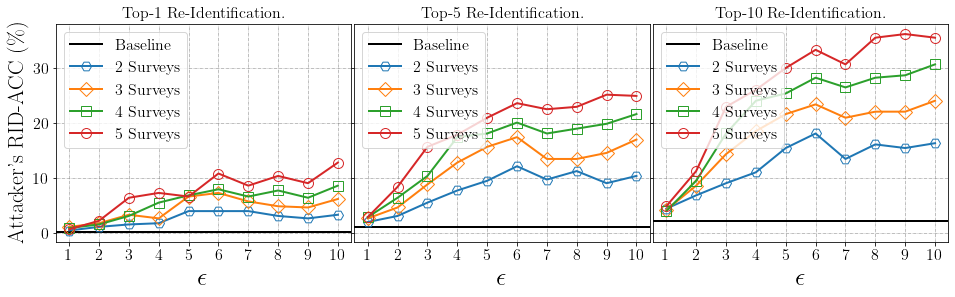

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_olh+'Smp_Re_Ident_Attack_LDP_PK_Uniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][eps_l][survey][top_k] for idx in range(nb_seed)]).astype(int) for eps_l in lst_eps])/n
        
        ax[r].plot(range(len(lst_eps)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel('$\epsilon$', fontsize=26)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_eps)))
    ax[r].set_xticklabels(lst_eps)
#     ax[r].set_ylim(-1, 35)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Reidentification Smp[OLH]: No Knowledge, Non-Uniform $\epsilon$

In [13]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus = nb_cores)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack = {} 

# Partial Knowledge
df_pk = df[np.random.choice(attributes, np.random.randint(min_att_per_survey, d), replace=False)]

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each epsilon
for eps_l in lst_eps: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            # OLH parameters 
            g = int(round(np.exp(eps_l))) + 1

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    
                    lh_val, rnd_seed_id = LH_Client(row[att], eps_l, optimal=True)
                    
                    lst_plaus_denia = []
                    for v in range(k):
                        if lh_val == (xxhash.xxh32(str(v), seed=rnd_seed_id).intdigest() % g):
                            lst_plaus_denia.append(v)
                    
                    if len(lst_plaus_denia) > 0:
                        dic_id[row['ID']][att].append(np.random.choice(lst_plaus_denia))
                    else:
                        dic_id[row['ID']][att].append(np.random.randint(k))

            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df_pk)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack[eps_l] = atk_top_k

# Saving to local file
np.save(filename_olh+'Smp_Re_Ident_Attack_LDP_PK_NonUniform_Seed_'+str(my_seed)+'.npy', re_ident_attack) 
    
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 35.57817840576172 seconds


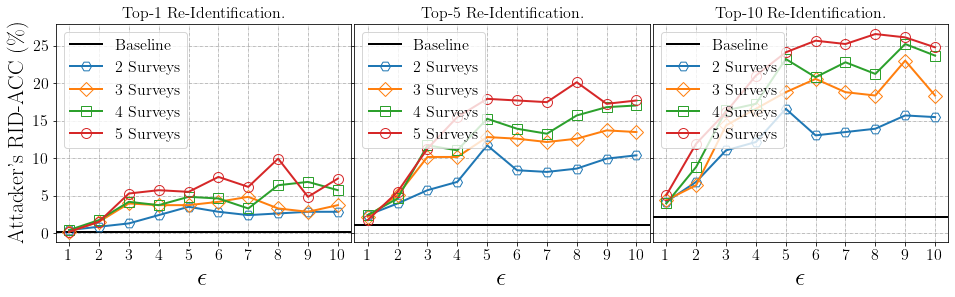

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_olh+'Smp_Re_Ident_Attack_LDP_PK_NonUniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][eps_l][survey][top_k] for idx in range(nb_seed)]).astype(int) for eps_l in lst_eps])/n
        
        ax[r].plot(range(len(lst_eps)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel('$\epsilon$', fontsize=26)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_eps)))
    ax[r].set_xticklabels(lst_eps)
#     ax[r].set_ylim(-1, 35)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Static parameters for $\alpha$-PIE

In [15]:
#number of users (n)
n = df.shape[0]
print('Number of Users =',n)

#number of dimensions (d)
d = len(attributes)
print('Number of Attributes =', d)

#domain size of attributse
lst_k = [len(df[att].unique()) for att in attributes]
print('Domain size of attributes =', lst_k)

#number of surveys (nb_surveys)
nb_surveys = 5
print('Number of Surveys =', nb_surveys)

#min number of attributes per survey
min_att_per_survey = np.rint(d/2).astype(int)
print('Min number of attributes per survey =', min_att_per_survey)

#The minimum number of users reporting each attribute to ensure a set size |U|
n_d = int(n/min_att_per_survey)
print('Min number of users per attribute =', n_d)

#range of bayes_error 
lst_bayes_error = [round(val, 2) for val in np.arange(0.5, 1, 0.05)[::-1]]
print('Bayes Error values =', lst_bayes_error)

Number of Users = 452
Number of Attributes = 10
Domain size of attributes = [59, 6, 16, 6, 13, 6, 5, 2, 20, 2]
Number of Surveys = 5
Min number of attributes per survey = 5
Min number of users per attribute = 90
Bayes Error values = [0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5]


In [16]:
def get_eps_from_bayes_error(bayes_error, n, k):

    min_term = min(np.log2(n), np.log2(k)) #from Eq.(16) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    alpha = - ((bayes_error - 1) * np.log2(n) - 1) #from Eq.(12) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    eq = ((k-1)*alpha + min_term)/(min_term - alpha) #from Eq.() of our paper

    if eq < 0: #from Prop. 9 of PIA privacy paper [1] from Murakami & Takahashi (2021).
        #Proposition 9 states that we do not need to use LDP when the I(U;X) is small (i.e., for small domain sizes k). 

        return 0 #the 0 value will represent that no budget was consumed
        
    else:
        #if domain size is large, an LDP mechanism is required.

        return np.log(eq) #from Eq.() of our paper

In [17]:
def generic_get_eps_from_bayes_error(bayes_error, n, k):

    min_term = min(np.log2(n), np.log2(k)) #from Eq.(16) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    alpha = - ((bayes_error - 1) * np.log2(n) - 1) #from Eq.(12) of PIA privacy paper [1] from Murakami & Takahashi (2021).

    eps = alpha/np.log2(np.e) #from Eq.(14) of PIA privacy paper [1] from Murakami & Takahashi (2021).
    
    if eps * np.log2(np.e) > min_term: 

        return 0 #the 0 value will represent that no budget was consumed
        
    else:
        
        return eps #from Eq.() of our paper

## Reidentification Smp[GRR]: No Knowledge, Surveys with Different Attributes, Uniform $\alpha$

In [18]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus = nb_cores)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack_pie = {} 

# Partial Knowledge
df_pk = df[np.random.choice(attributes, np.random.randint(min_att_per_survey, d), replace=False)]

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each bayes error
for bayes_error in lst_bayes_error: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    
                    #calculate required epsilon to satisfy the bayes error 
                    eps_l = get_eps_from_bayes_error(bayes_error, n_d, k)

                    # OLH parameters 
                    g = int(round(np.exp(eps_l))) + 1
                    
                    if eps_l > 0:
                    
                        lh_val, rnd_seed_id = LH_Client(row[att], eps_l, optimal=True)

                        lst_plaus_denia = []
                        for v in range(k):
                            if lh_val == (xxhash.xxh32(str(v), seed=rnd_seed_id).intdigest() % g):
                                lst_plaus_denia.append(v)

                        if len(lst_plaus_denia) > 0:
                            dic_id[row['ID']][att].append(np.random.choice(lst_plaus_denia))
                        else:
                            dic_id[row['ID']][att].append(np.random.randint(k))
                    else:
                        dic_id[row['ID']][att].append(row[att])

                #select another non-reported attribute for the user
                else:
                    
                    #select at random a non-reported attribute
                    add_att = np.random.choice(np.where(np.array([len(dic_id[row['ID']][att]) for att in attributes])==0)[0])

                    new_att = attributes[add_att] #select the new attribute

                    new_k = lst_k[add_att] #domain size of new attribute
                    
                    #calculate required epsilon to satisfy the bayes error 
                    new_eps_l = get_eps_from_bayes_error(bayes_error, n_d, new_k)

                    # OLH parameters 
                    new_g = int(round(np.exp(new_eps_l))) + 1
                    
                    if new_eps_l > 0:

                        new_lh_val, new_rnd_seed_id = LH_Client(row[new_att], new_eps_l, optimal=True)

                        new_lst_plaus_denia = []
                        for new_v in range(new_k):
                            if new_lh_val == (xxhash.xxh32(str(new_v), seed=new_rnd_seed_id).intdigest() % new_g):
                                new_lst_plaus_denia.append(new_v)

                        if len(new_lst_plaus_denia) > 0:
                            dic_id[row['ID']][new_att].append(np.random.choice(new_lst_plaus_denia))
                        else:
                            dic_id[row['ID']][new_att].append(np.random.randint(new_k))
                    else:
                        dic_id[row['ID']][new_att].append(row[new_att])
            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df_pk)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack_pie[bayes_error] = atk_top_k

# Saving to local file
np.save(filename_olh+'Smp_Re_Ident_Attack_PIE_PK_Uniform_Seed_'+str(my_seed)+'.npy', re_ident_attack_pie) 
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 38.56813454627991 seconds


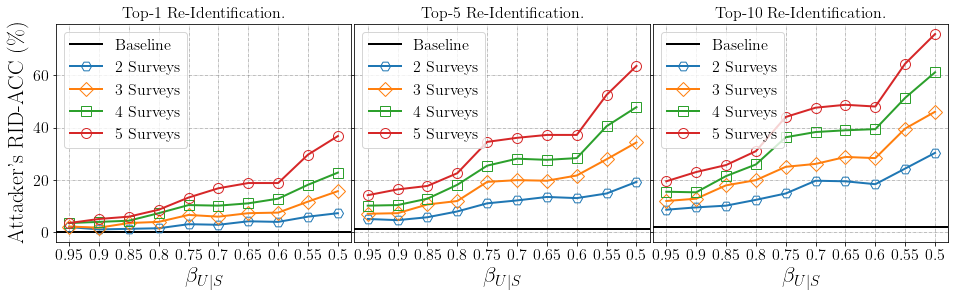

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_olh+'Smp_Re_Ident_Attack_PIE_PK_Uniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][bayes_error][survey][top_k] for idx in range(nb_seed)]).astype(int) for bayes_error in lst_bayes_error])/n
        
        ax[r].plot(range(len(lst_bayes_error)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel(r'$\beta_{U|S}$', fontsize=22)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_bayes_error)))
    ax[r].set_xticklabels(lst_bayes_error)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

## Reidentification Smp[GRR]: No Knowledge, Non-Uniform $\alpha$

In [20]:
starttime = time.time()

ray.shutdown()

nb_cores = 12
ray.init(num_cpus = nb_cores)

#run experiments 'nb_seed' times
# for seed in range(nb_seed):
print(my_seed)

np.random.seed(my_seed) 

# initialize dictionary to save number of people re-identified per epsilon
re_ident_attack_pie = {} 

# Partial Knowledge
df_pk = df[np.random.choice(attributes, np.random.randint(min_att_per_survey, d), replace=False)]

# divide the dataset in nb_cores equal parts for later parallelization with Ray library
lst_idx_per_core = [list(_) for _ in np.array_split(df.index, nb_cores)]

# Randomly choose the number of attributes for each survey between min_att_per_survey and d
nb_att_survey = np.random.randint(min_att_per_survey, d, nb_surveys)

# Randomly select the indexes of the attributes for each survey
lst_att_survey = [np.random.choice(range(d), nb, replace=False) for nb in nb_att_survey]

#for each bayes error
for bayes_error in lst_bayes_error: 

    #Initializing a dictionary for each users' profile
    dic_id = {ID:{att:[] for att in attributes} for ID in range(n)}

    #Dictionary to save number of re-identified profiles per top-k group
    atk_top_k = {survey:{top_k:0 for top_k in range(1, 11)} for survey in range(1, nb_surveys + 1)}

    #For each survey
    for survey in range(1, nb_surveys + 1):  

        # we'll shuffle the users' order in the dataset
        df_shfl = df.sample(frac=1, random_state=my_seed+survey) #change seed with survey
        df_shfl.reset_index(drop=True, inplace=True)

        # we'll partitionate the users indexes to separate in nb_att_survey groups (i.e., to report a single attribute)
        lst_index = [list(_) for _ in np.array_split(df_shfl.index, nb_att_survey[survey - 1])]

        idx=0 #index for attribute
        for index_att in lst_att_survey[survey - 1]: #for each attribute of the survey

            att = attributes[index_att] #select attribute

            k = lst_k[index_att] #domain size of attribute

            # select users that report this attribute
            for ind, row in df_shfl.iloc[lst_index[idx]].iterrows():

                #confirm the user has never reported this attribute
                if len(dic_id[row['ID']][att]) == 0:
                    
                    #calculate required epsilon to satisfy the bayes error 
                    eps_l = get_eps_from_bayes_error(bayes_error, n_d, k)

                    # OLH parameters 
                    g = int(round(np.exp(eps_l))) + 1
                    
                    if eps_l > 0:
                    
                        lh_val, rnd_seed_id = LH_Client(row[att], eps_l, optimal=True)

                        lst_plaus_denia = []
                        for v in range(k):
                            if lh_val == (xxhash.xxh32(str(v), seed=rnd_seed_id).intdigest() % g):
                                lst_plaus_denia.append(v)

                        if len(lst_plaus_denia) > 0:
                            dic_id[row['ID']][att].append(np.random.choice(lst_plaus_denia))
                        else:
                            dic_id[row['ID']][att].append(np.random.randint(k))
                    else:
                        dic_id[row['ID']][att].append(row[att])

            idx+=1

        #start attacking after 2 surveys
        if survey >= 2:

            result_parallel = [] #initialize list for parallelized results
            for lst_idx in lst_idx_per_core: 

                result_parallel.append(attack_re_identification.remote(lst_idx, dic_id, df_pk)) #use remote function from Ray library

            parallel_atk = list(flatten(ray.get(result_parallel))) #take results with get function from Ray library

            lst_top_k = np.zeros(11) #initialize list of top-k re-identification attack

            for idx in range(len(parallel_atk)): #for each attacked profile

                for top_k in range(parallel_atk[idx], 11): #count as attack the top-k's group
                    lst_top_k[top_k] += 1

            atk_top_k[survey] = lst_top_k #store attack result for this number of surveys

    #for each epsilon we save the number of re-identified profiles for all top-k
    re_ident_attack_pie[bayes_error] = atk_top_k

# Saving to local file
np.save(filename_olh+'Smp_Re_Ident_Attack_PIE_PK_NonUniform_Seed_'+str(my_seed)+'.npy', re_ident_attack_pie) 
print('That took {} seconds'.format(time.time() - starttime))    

0
That took 39.16793513298035 seconds


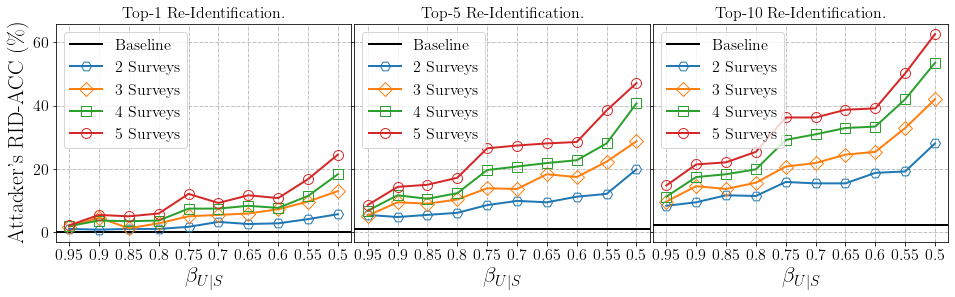

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), sharey=True)
plt.subplots_adjust(wspace=0.01)

r = 0 #row

markers = ['H', 'D', 's', 'o'] 
lines = ['dashed', 'dotted', 'dashdot', (0, (1, 10))]

for top_k in [1, 5, 10]:
    ax[r].grid(color='grey', linestyle='dashdot', linewidth=0.5)
    ax[r].axhline(y= 100 * top_k/n, color='black', label='Baseline') #our baseline is a random top-k group
    
    #averaging results over nb_seed times
    for survey in range(2, nb_surveys + 1):
        
        lst_resul_atk = []
        for seed in range(nb_seed):
            lst_resul_atk.append(np.load(filename_olh+'Smp_Re_Ident_Attack_PIE_PK_NonUniform_Seed_'+str(seed)+'.npy', allow_pickle=True).reshape(-1))
        
        error_rate_atk = 100 * np.array([np.mean([lst_resul_atk[idx][0][bayes_error][survey][top_k] for idx in range(nb_seed)]).astype(int) for bayes_error in lst_bayes_error])/n
        
        ax[r].plot(range(len(lst_bayes_error)), error_rate_atk, label=str(survey)+' Surveys', marker=markers[survey-2], markerfacecolor='none')

    ax[r].set_title('Top-'+ str(top_k)+ ' Re-Identification.')
    ax[r].set_xlabel(r'$\beta_{U|S}$', fontsize=22)
    ax[0].set_ylabel("Attacker's RID-ACC (\%)", fontsize=22)
    ax[r].set_xticks(range(len(lst_bayes_error)))
    ax[r].set_xticklabels(lst_bayes_error)
    ax[r].legend(loc='upper left')
    
    r += 1 
    
# plt.savefig(, dpi=500, bbox_inches = 'tight',pad_inches = 0.1)
plt.show()

Please execute with more seeds for more stable plots and with the whole dataset for similar results to the paper